In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from tensorflow import keras
from keras import layers

In [3]:
zip_train = '../input/facial-keypoints-detection/training.zip'
zip_test = '../input/facial-keypoints-detection/test.zip'
extract_to_path = '../working/'

with zipfile.ZipFile(zip_train, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
with zipfile.ZipFile(zip_test, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [4]:
data = pd.read_csv('../working/training.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [5]:
all_image = []
for all_pixel in data['Image'].values:
    image = list(map(int,all_pixel.split(' ')))
    all_image.append(image)

In [ ]:
#image = [list(map(int, all_pixel.split(' '))) for all_pixel in data['Image'].values]

In [6]:
all_image = np.array(all_image).reshape(-1,96,96)

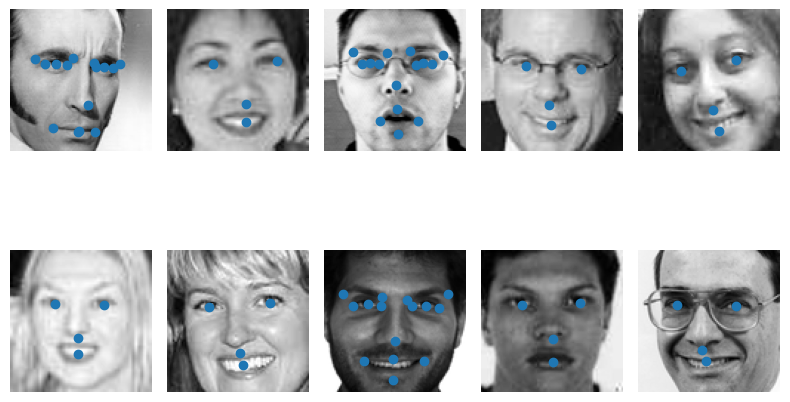

In [7]:
def visual_key_point(row=5,col=5):
    fig,ax = plt.subplots(row,col,figsize=(8,6))
    ax=ax.flatten()
    for i in range(len(ax)):
        sample = np.random.randint(0,all_image.shape[0])
        ax[i].imshow(all_image[sample],cmap='gray')
        x = data.iloc[sample,[i for i in range(0,30,2)]]
        y = data.iloc[sample,[i+1 for i in range(0,30,2)]]
        ax[i].scatter(x,y)
        ax[i].axis('off')

    plt.tight_layout()

visual_key_point(2,5)

In [8]:
data_new = data.dropna()
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float64
 1

### Predict the missing value using XGBoost

In [9]:
value = list(range(0, 4)) + list(range(20, 22)) + list(range(28,30))
target = list(range(4,20)) + list(range(22, 28))
x_train,x_test,y_train,y_test = train_test_split(data_new.iloc[:,value],data_new.iloc[:,target],
                                                test_size = 0.1,random_state = 42)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1926, 8) (1926, 22)
(214, 8) (214, 22)


In [10]:
def evaluation(model,x_test,y_test):
    print(model.__class__.__name__)  
    print('--------------------')
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)

    print('MAE: {}'.format(mae))
    print('MSE: {}'.format(mse))
    print('R2: {}'.format(r2))

    return [mae,mse,r2]

In [11]:
xgb = XGBRegressor()
xgb.fit(x_train,y_train)
score_xgb = evaluation(xgb,x_test,y_test)

XGBRegressor
--------------------
MAE: 1.3729632165567536
MSE: 3.716068721471615
R2: 0.6379608755669731


In [12]:
y_pred = xgb.predict(data.iloc[:,value])

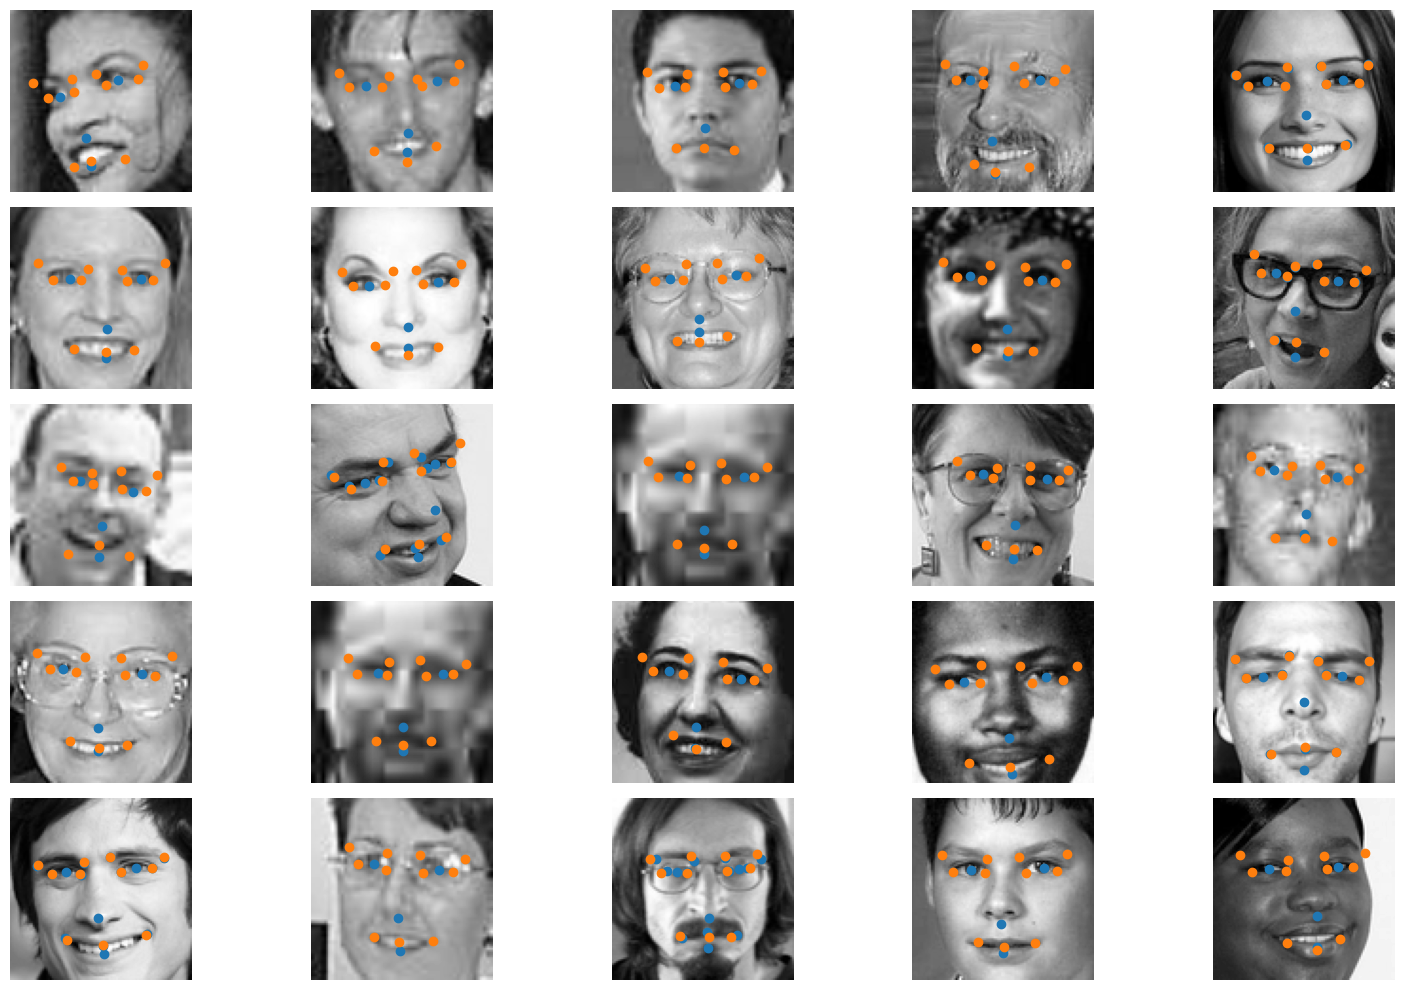

In [13]:
def visual_key_point(row=5,col=5):
    fig,ax = plt.subplots(row,col,figsize=(16,10))
    ax=ax.flatten()
    for i in range(len(ax)):
        sample = np.random.randint(0,all_image.shape[0])
        ax[i].imshow(all_image[sample],cmap='gray')
        x = data.iloc[sample,[i for i in range(0,30,2)]]
        y = data.iloc[sample,[i+1 for i in range(0,30,2)]]
        ax[i].scatter(x,y)
        
        x = [y_pred[sample][i] for i in range(0,len(target),2)]
        y = [y_pred[sample][i+1] for i in range(0,len(target),2)]
        ax[i].scatter(x,y)
        ax[i].axis('off')
    
    plt.tight_layout()

visual_key_point(5,5)

In [14]:
data_values = data.iloc[:, target].values
y_pred_values = np.array(y_pred) 
data.iloc[:, target] = np.where(np.isnan(data_values), y_pred_values, data_values)

In [15]:
data_new = data.dropna()
data_new.shape

(7000, 31)

In [16]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7000 non-null   float64
 1   left_eye_center_y          7000 non-null   float64
 2   right_eye_center_x         7000 non-null   float64
 3   right_eye_center_y         7000 non-null   float64
 4   left_eye_inner_corner_x    7000 non-null   float64
 5   left_eye_inner_corner_y    7000 non-null   float64
 6   left_eye_outer_corner_x    7000 non-null   float64
 7   left_eye_outer_corner_y    7000 non-null   float64
 8   right_eye_inner_corner_x   7000 non-null   float64
 9   right_eye_inner_corner_y   7000 non-null   float64
 10  right_eye_outer_corner_x   7000 non-null   float64
 11  right_eye_outer_corner_y   7000 non-null   float64
 12  left_eyebrow_inner_end_x   7000 non-null   float64
 13  left_eyebrow_inner_end_y   7000 non-null   float64
 1

In [17]:
all_image = []
for all_pixel in data_new['Image'].values:
    image = list(map(int,all_pixel.split(' ')))
    all_image.append(image)

In [18]:
all_image = np.array(all_image).reshape(-1,96,96)

In [19]:
target = data_new.drop('Image',axis=1).values
x_train,x_test,y_train,y_test = train_test_split(all_image,target,
                                                test_size = 0.1,
                                                random_state = 42)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(6300, 96, 96) (6300, 30)
(700, 96, 96) (700, 30)


### Modeling - CNN

In [20]:
layers.Conv2D

keras.src.layers.convolutional.conv2d.Conv2D

In [21]:
class CNN(keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = self.block_conv2d(16,16)
        self.conv2 = self.block_conv2d(32,32)
        self.conv3 = self.block_conv2d(64,64)
        self.conv4 = self.block_conv2d(128,128)

        self.fc = keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation = 'leaky_relu'),
            layers.Dense(256, activation = 'leaky_relu'),
            layers.Dense(30)
        ])

    def block_conv2d(self,in_channel,out_channel):
        return keras.Sequential([
            layers.Conv2D(in_channel,3),
            layers.BatchNormalization(),
            layers.Activation('leaky_relu'),
            layers.Conv2D(out_channel,3),
            layers.BatchNormalization(),
            layers.Activation('leaky_relu'),
            layers.MaxPooling2D((2,2))
        ])

    def call(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x

In [22]:
model = CNN()
model(np.random.rand(32,96,96,1))
model.summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 46, 46, 16)            │           2,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 21, 21, 32)            │          14,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (32, 8, 8, 64)              │          55,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (32, 2, 2, 128)             │         222,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (32, 30)                    │         106,398 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 401,550 (1.53 MB)

 Trainable params: 400,590 (1.53 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
learning_rate = 0.001
batch_size = 32
epochs = 50
factor = 0.2

model.compile(
    loss=keras.losses.LogCosh(),
    metrics=[keras.metrics.LogCoshError()], 
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= factor, patience=3, min_lr=1e-7)

H = model.fit(
    x_train, y_train, batch_size=batch_size,
    validation_split = 0.1,
    steps_per_epoch = x_train.shape[0] // batch_size,
    epochs = epochs,
    callbacks = [early_stopping , reduce_lr]
)

Epoch 1/50
178/196 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - logcosh: 13.4334 - loss: 13.4334

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


196/196 ━━━━━━━━━━━━━━━━━━━━ 69s 322ms/step - logcosh: 13.0432 - loss: 13.0432 - val_logcosh: 6.0852 - val_loss: 6.0852 - learning_rate: 0.0010
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 316ms/step - logcosh: 5.2527 - loss: 5.2527 - val_logcosh: 2.0581 - val_loss: 2.0581 - learning_rate: 0.0010
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 316ms/step - logcosh: 2.1905 - loss: 2.1905 - val_logcosh: 2.3738 - val_loss: 2.3738 - learning_rate: 0.0010
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 315ms/step - logcosh: 1.9976 - loss: 1.9976 - val_logcosh: 1.8129 - val_loss: 1.8129 - learning_rate: 0.0010
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 314ms/step - logcosh: 1.7979 - loss: 1.7979 - val_logcosh: 1.5596 - val_loss: 1.5596 - learning_rate: 0.0010
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 317ms/step - logcosh: 1.6321 - loss: 1.6321 - val_logcosh: 1.4555 - val_loss: 1.4555 - learning_rate: 0.0010
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 315ms/step - logcosh: 1.3876 - loss: 1.3876 - v

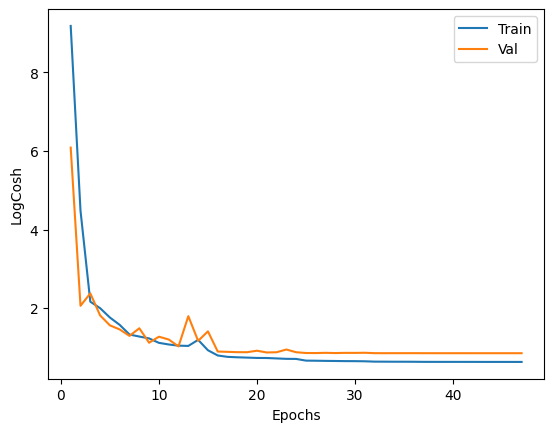

In [24]:
score_train = H.history['logcosh']
score_val = H.history['val_logcosh']

num_epoch = len(score_train)
plt.plot(range(1,num_epoch+1) , score_train , label = 'Train')
plt.plot(range(1,num_epoch+1) , score_val, label = 'Val')
plt.xlabel('Epochs')
plt.ylabel('LogCosh')
plt.legend()

In [25]:
evaluation(model,x_test,y_test)

CNN
--------------------
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step
MAE: 1.3179216455434286
MSE: 3.6900092583962616
R2: 0.7196323468948259


[1.3179216455434286, 3.6900092583962616, 0.7196323468948259]

### Submit

In [26]:
data_test = pd.read_csv('../working/test.csv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [27]:
all_image_test = [list(map(int,image.split(' '))) for image in data_test['Image'].values]
all_image_test = np.array(all_image_test).reshape(-1,96,96)
all_image_test.shape

(1783, 96, 96)

In [28]:
y_pred = model.predict(all_image_test)
y_pred.shape

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step


(1783, 30)

In [29]:
pattern = pd.read_csv('../input/facial-keypoints-detection/IdLookupTable.csv')
pattern.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [30]:
pattern.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RowId        27124 non-null  int64  
 1   ImageId      27124 non-null  int64  
 2   FeatureName  27124 non-null  object 
 3   Location     0 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 847.8+ KB


In [31]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = data.drop('Image',axis=1).columns

In [32]:
y_pred_df.index = [i for i in range(1,len(y_pred_df)+1)]

In [33]:
for i, j in zip(pattern['ImageId'].values, pattern['FeatureName']):
    pattern.loc[(pattern['ImageId'] == i) & (pattern['FeatureName'] == j), 'Location'] = y_pred_df.loc[i, j]

In [34]:
submit = pattern.drop(['ImageId','FeatureName'],axis=1)

In [ ]:
submit.to_csv('submission.csv',index=False)